In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


In [7]:
'''
用户标识（uId）匿名化处理后的用户唯一标识（ID取值从1000001开始，依次递增）
年龄段（age_group）年龄范围（取值1； 2； 3； 4； 5；6；）'''
label = pd.read_csv("data/age_train.csv",header=None)
label.columns = ['uId','age_group']

In [8]:
'''
用户标识（uId）匿名化处理后的用户唯一标识（ID取值从1000001开始，依次递增）
'''
test = pd.read_csv("data/age_test.csv",header=None)
test.columns = ['uId']

In [4]:
'''
用户标识（uId）匿名化处理后的用户唯一标识（ID取值从1000001开始，依次递增）
开机次数（bootTimes）一段时间内(30天)手机的总开机次数
手机A特性使用次数（AFuncTimes）一段时间内(30天) 手机A特性使用次数
手机B特性使用次数（BFuncTimes）一段时间内(30天) 手机B特性使用次数
手机C特性使用次数（CFuncTimes）一段时间内(30天) 手机C特性使用次数
手机D特性使用次数（DFuncTimes）一段时间内(30天) 手机D特性使用次数
手机E特性使用次数（EFuncTimes）一段时间内(30天) 手机E特性使用次数
手机F特性使用次数（FFuncTimes）一段时间内(30天) 手机F特性使用次数
手机G特性使用情况（FFuncSum）一段时间内(30天)G特性使用情况（数值）'''
behavior = pd.read_csv("data/user_behavior_info.csv",header=None)
behavior.columns = ['uId','bootTimes','AFuncTimes','BFuncTimes','CFuncTimes','DFuncTimes','EFuncTimes','FFuncTimes','GFuncTimes']

In [2]:
'''
应用标识（appId）appId为app应用的唯一标识
应用类型（category）app所属的应用类型
'''
app_info = pd.read_csv("data/app_info.csv",header=None)
app_info.columns = ['appId','category']


#  category 为主键，每个下的appid数量


In [61]:
app_info.nunique()

appId       167622
category        40
dtype: int64

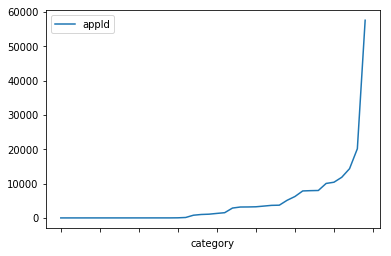

In [68]:
app_info.groupby('category').count().sort_values('appId').plot()

In [6]:
'''
用户标识（uId）匿名化处理后的用户唯一标识（ID取值从1000001开始，依次递增）
性别（gender）男/女（取值空间0,1）
常住地（city）如深圳市、南京市等（匿名化处理，实际取值c001，c002….）
手机型号（prodName）如mate10、honor 10等（匿名化处理，实际取值p001、p002……）
手机ram容量（ramCapacity）手机ram的大小，以G为单位
ram剩余容量占比（ramLeftRation）手机剩余的容量占总容量的比例
rom容量（romCapacity）手机rom的大小，以G为单位
rom剩余容量占比（romLeftRation）手机剩余rom容量占总rom容量的比例
手机颜色（color）手机机身的颜色
字体大小（fontSize）手机设置的字体大小
上网类型（ct）2G/3G/4G/WIFI
移动运营商（carrier）移动/联通/电信/其他
手机系统版本（os）AndroId操作系统的版本号
'''

user_info = pd.read_csv('data/user_basic_info.csv',header=None)
user_info.columns = ['uId','gender','city','prodName','ramCapacity','ramLeftRation','romCapacity'
,'romLeftRation','color','fontSize','ct','carrier','os']

In [69]:
cate = ['gender','city','prodName','color','ct','carrier','os']
user_info[cate].nunique()

gender        2
city        363
prodName    227
color       136
ct            7
carrier       4
os           16
dtype: int64

In [16]:
# 内存不够，这个先不用
# ---------------------------------------------------------------------
'''
用户标识（uId）匿名化处理后的用户唯一标识（ID取值从1000001开始，依次递增）
应用标识（appId）匿名化处理后的app唯一标识
使用时长（duration）1天内用户对某app的累计使用时长
打开次数（times）1天内用户对某app的累计打开次数
使用日期（use_date）用户对某app的使用日期
'''
usage = pd.read_csv('data/user_app_usage.csv',header=None)
usage.columns = ['uId','appId','duration','times','use_date']

KeyboardInterrupt: 

In [3]:
'''
用户标识（uId）匿名化处理后的用户唯一标识（ID取值从1000001开始，依次递增）
应用标识（appId）匿名化处理后的app唯一标识'''
active = pd.read_csv("data/user_app_actived.csv",header=None)
active.columns = ['uId','appId']

In [4]:
active['appId'] = active['appId'].apply(lambda x:x.split('#'))
active['appNum'] = active['appId'].apply(lambda x:len(x) if x[0]!='\\N' else 0)
active['appNum'].describe()

count    2.512500e+06
mean     4.051719e+01
std      2.283547e+01
min      0.000000e+00
25%      2.400000e+01
50%      3.700000e+01
75%      5.200000e+01
max      8.880000e+02
Name: appNum, dtype: float64

In [12]:
tmp = active['appId'].values
appid= set()
for each in tmp:
    appid |= set(each)
len(appid)

9401

In [14]:
a = set(app_info['appId'].values) 

In [21]:
# 统计每个appId激活人数，和激活人的属性分布，年龄、性别、城市、手机型号等属性

le = LabelEncoder()
app_info['category'] = le.fit_transform(app_info['category'])

key = app_info.appId.values
val = app_info.category.values

from collections import defaultdict as dd

app_map = dd(int)
for i in range(len(key)):
     app_map[key[i]] = val[i]
        
"""
# 统计每个用户 每个app类别下的激活app的比例，贝叶斯平滑 ,有的激活appid不在app_info中,那就不计算，也把其的数目减掉
tmp = active['appId'].values
res = []
for i in tqdm(range(len(tmp))):
    line = [0.0]*(len(app_map)+1)
    # 这个用户总共激活多少app
    cnt = len(tmp[i])
    for app in tmp[i]:
        line[app_map[app]] += 1
    for j in range(len(line)):
        line[j] /= cnt
    res.append(line[:])
"""

SyntaxError: invalid syntax (<ipython-input-21-b17b3ae1774e>, line 19)

In [22]:
# 每个用户激活了几种类别的app
def app_cate_data(x,t):
    cate = dd(int)
    for each in x:    
        cate[app_map[each]] += 1
    tmp = cate.values()
    s = sum(tmp)+1
    # all_num
    if t == 0:
        return len(cate)
    # max_num
    elif t == 1:
        return max(tmp)/s
    # min_num
    else:
        return min(tmp)/s
        
active['app_cate_num'] = active['appId'].apply(lambda x: app_cate_num(x,0))

#平均每种app激活多少
active['app_cate_mean'] = active['appNum']/active['app_cate_num']

# 激活最多种类的app数目、占所有激活数目比例
active['app_cate_maxRate'] = active['appId'].apply(lambda x: app_cate_num(x,1))
active['app_cate_minRate'] = active['appId'].apply(lambda x: app_cate_num(x,2))
active['app_cate_max'] = active['app_cate_maxRate'] * (active['appNum']+1)
active['app_cate_min'] = active['app_cate_minRate'] * (active['appNum']+1)

In [25]:
active[['appNum','app_cate_num']]

,appNum,app_cate_num
921891,0,1
1742332,0,1
1330304,0,1
832218,2,1
1813617,1,1
643219,1,1
2359516,0,1
1708052,2,1
684047,0,1
2471818,0,1


In [9]:
train_cols = label.shape[0]
data = pd.concat([label,test])
data = data.merge(user_info,on='uId',how='left')
data = data.merge(behavior,on='uId',how='left')
del active['appId']
data = data.merge(active,on='uId',how='left')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [11]:
print(data.info())
print(data.columns)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2512500 entries, 0 to 2512499
Data columns (total 23 columns):
age_group        float64
uId              int64
gender           int64
city             object
prodName         object
ramCapacity      float64
ramLeftRation    float64
romCapacity      float64
romLeftRation    float64
color            object
fontSize         float64
ct               object
carrier          object
os               float64
bootTimes        int64
AFuncTimes       float64
BFuncTimes       float64
CFuncTimes       float64
DFuncTimes       float64
EFuncTimes       float64
FFuncTimes       float64
GFuncTimes       int64
appNum           int64
dtypes: float64(13), int64(5), object(5)
memory usage: 460.1+ MB
None
Index(['age_group', 'uId', 'gender', 'city', 'prodName', 'ramCapacity',
       'ramLeftRation', 'romCapacity', 'romLeftRation', 'color', 'fontSize',
       'ct', 'carrier', 'os', 'bootTimes', 'AFuncTimes', 'BFuncTimes',
       'CFuncTimes', 'DFuncTimes', 'E

In [52]:
train = data.iloc[:train_cols]
test = data.iloc[train_cols:]
del test['age_group']
cate = ['gender','city','prodName','color','ct','carrier','os']
y = train['age_group'] - 1
del train['age_group']
X = train
del train

In [70]:
feat_dict = {}
for f in ['city','prodName','color','gender','ct','carrier','os']
    le = LabelEncoder()
    X[f] = le.fit_transform(X[f])
    feat_dict[f] = X[f].nunique()

In [95]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'max_depth': 5,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.85,
    'bagging_fraction': 0.85,
    'bagging_freq': 5,
    'verbose': 1,
    'num_threads': 4,
    'lambda_l2': 1.0,
    'min_gain_to_split': 0,
    'num_class': 6,
}
n_splits = 5
seed = 2019
x_score = []    # 交叉验证各折的accuracy值
cv_pred = []    # 各折的预测值
'''
skf = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=True)
# 交叉验证
for index, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(index)
    X_train, X_valid, y_train, y_valid = X[train_index], X[test_index], y[train_index], y[test_index]
    train_data = lgb.Dataset(X_train, label=y_train)    # 训练数据
    validation_data = lgb.Dataset(X_valid, label=y_valid)   # 验证数据
    clf = lgb.train(lgb_params, train_data, num_boost_round=5000, valid_sets=[validation_data],
                    early_stopping_rounds=100, feval=accuracy_score, verbose_eval=1)     # 训练

    x_pred = clf.predict(X_valid, num_iteration=clf.best_iteration)
    x_pred = [np.argmax(x) for x in x_pred]
    x_score.append(accuracy_score(y_valid, x_pred))  # 计算accuracy值
    y_test = clf.predict(X_test, num_iteration=clf.best_iteration)  # 预测
    y_test = [np.argmax(x) for x in y_test]
    if index == 0:
        cv_pred = np.array(y_test).reshape(-1, 1)
    else:
        cv_pred = np.hstack((cv_pred, np.array(y_test).reshape(-1, 1)))
    if index == 4:
        lgb.plot_importance(clf, figsize=(50, 50))  # 画出重要特征
        plt.title("Feature_importance")
        plt.show()
        
'''

train_data = lgb.Dataset(X,y)

model = lgb.train(
        lgb_params,
        train_data,
        num_boost_round=5000,
        valid_sets=[train_data],
        early_stopping_rounds=100,
        verbose_eval=50,
    )


lgb.plot_importance(model, figsize=(50, 50))  # 画出重要特征
plt.title("Feature_importance")
plt.show()

Training until validation scores don't improve for 100 rounds.
[50]	training's multi_logloss: 1.47813
[100]	training's multi_logloss: 1.42652


KeyboardInterrupt: 

In [63]:
train_data.feature_name


['uId',
 'gender',
 'city',
 'prodName',
 'ramCapacity',
 'ramLeftRation',
 'romCapacity',
 'romLeftRation',
 'color',
 'fontSize',
 'ct',
 'carrier',
 'os',
 'bootTimes',
 'AFuncTimes',
 'BFuncTimes',
 'CFuncTimes',
 'DFuncTimes',
 'EFuncTimes',
 'FFuncTimes',
 'GFuncTimes',
 'appNum']

In [87]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2010000 entries, 0 to 2009999
Data columns (total 44 columns):
uId              int64
ramCapacity      float64
ramLeftRation    float64
romCapacity      float64
romLeftRation    float64
fontSize         float64
bootTimes        int64
AFuncTimes       float64
BFuncTimes       float64
CFuncTimes       float64
DFuncTimes       float64
EFuncTimes       float64
FFuncTimes       float64
GFuncTimes       int64
appNum           int64
0                uint8
1                uint8
2g               uint8
2g#wifi          uint8
3g               uint8
3g#wifi          uint8
4g               uint8
4g#wifi          uint8
wifi             uint8
China_Mobile     uint8
China_Telecom    uint8
China_Unicom     uint8
othercp          uint8
4.0              uint8
4.1              uint8
4.2              uint8
4.3              uint8
4.4              uint8
5.0              uint8
5.1              uint8
6.0              uint8
6.1              uint8
6.3           